# Hop Teaming Analysis : Database Creation

## Team_Blimp

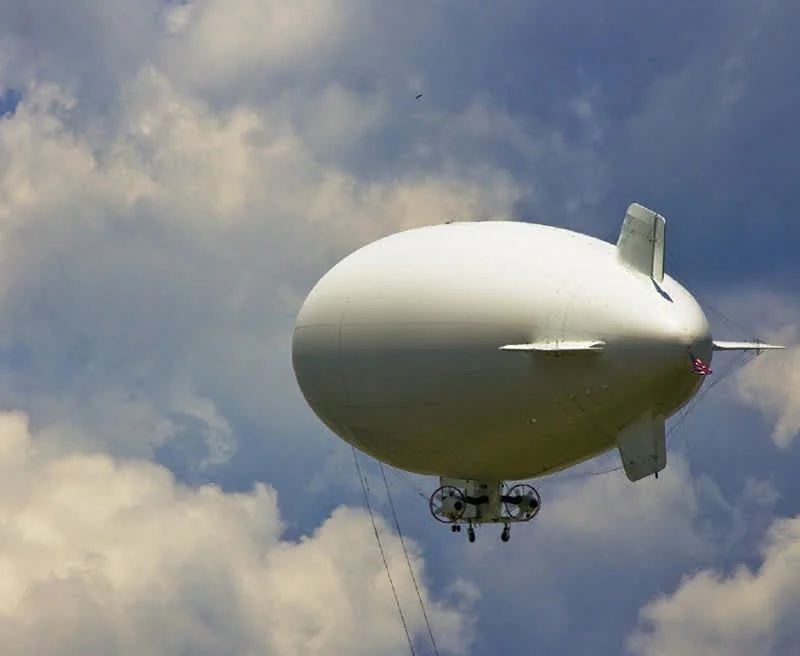


For this project the data was provided to us by our instructor Michael holloway. This project was a collaboration between Hayden Greer, Smita Misra, Tim Simpson and Asha Maheshwari. This notebook mainly comprise of code used for database creation. 

Four different dataset were used for database creation

* Hop Teaming dataset: This dataset aims to capture referrals between healthcare providers based on medicare claims.
  More information about the Hop teaming data can be found at https://careset.com/docgraph-hop-teaming-dataset/.

* NPPES dataset: For supplementing the Hop Teaming, the NPPES Data Dissemination was downloaded from  https://download.cms.gov/nppes/NPI_Files.html.

* Taxonomy Code dataset: For taxonomy code classification download from https://www.nucc.org/index.php/code-sets-mainmenu-41/provider-taxonomy-mainmenu-40/csv-mainmenu-57

* CBSA dataset: Download from https://www.huduser.gov/portal/datasets/usps_crosswalk.html


In [1]:
import pandas as pd
import sqlite3
from tqdm.notebook import tqdm

## Hop Team 

In [2]:
referrals =  pd.read_csv('Data/DocGraph_Hop_Teaming_2018.csv', nrows = 100)
referrals

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1508062167,1730166109,350,370,53.922,72.612
1,1508065640,1730166109,25,25,49.800,55.006
2,1508052093,1730166109,16,16,109.500,70.593
3,1508172545,1730166109,14,14,103.357,75.483
4,1508285131,1730166109,20,21,89.952,89.880
...,...,...,...,...,...,...
95,1508178229,1730166893,31,32,67.125,61.279
96,1508196445,1730166893,23,24,60.833,59.129
97,1508811076,1730166935,14,15,62.533,62.827
98,1508871252,1730166935,29,31,25.323,36.693


We wanted to eliminate "accidental" referrals, so we filtered the hop teaming data for the transaction_count at least 50 and the average_day_wait < 50.

In [3]:
db = sqlite3.connect('Data/hop_team.sqlite')

for chunk in tqdm(pd.read_csv('Data/DocGraph_Hop_Teaming_2018.csv', chunksize = 10000)):
    chunk = chunk[(chunk['transaction_count'] >= 50) & (chunk['average_day_wait'] < 50)]     # filter transaction_count is at least 50 and the average_day_wait is less than 50 
    chunk.to_sql('referral', db, if_exists = 'append', index = False)            # Append the chunk to a referral table

0it [00:00, ?it/s]

## NPPES

In [4]:
nppes = pd.read_csv('Data/npidata_pfile_20050523-20230212.csv', nrows = 10000)

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_59616/3325683896.py:1: DtypeWarning: Columns (17,24,64,68,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,89,90,147,151,155,157,159,161,163,165,167,169,170,171,174,175,178,314) have mixed types. Specify dtype option on import or set low_memory=False.
  nppes = pd.read_csv('Data/npidata_pfile_20050523-20230212.csv', nrows = 10000)


In [5]:
nppes.columns.tolist()

['NPI',
 'Entity Type Code',
 'Replacement NPI',
 'Employer Identification Number (EIN)',
 'Provider Organization Name (Legal Business Name)',
 'Provider Last Name (Legal Name)',
 'Provider First Name',
 'Provider Middle Name',
 'Provider Name Prefix Text',
 'Provider Name Suffix Text',
 'Provider Credential Text',
 'Provider Other Organization Name',
 'Provider Other Organization Name Type Code',
 'Provider Other Last Name',
 'Provider Other First Name',
 'Provider Other Middle Name',
 'Provider Other Name Prefix Text',
 'Provider Other Name Suffix Text',
 'Provider Other Credential Text',
 'Provider Other Last Name Type Code',
 'Provider First Line Business Mailing Address',
 'Provider Second Line Business Mailing Address',
 'Provider Business Mailing Address City Name',
 'Provider Business Mailing Address State Name',
 'Provider Business Mailing Address Postal Code',
 'Provider Business Mailing Address Country Code (If outside U.S.)',
 'Provider Business Mailing Address Telephone Nu

In [6]:
nppes.shape

(10000, 330)

The NPPES dataset contains a large number of fields, only a few of which are relevant: 

'NPI'
Entity Type, indicated by the 'Entity Type Code' field:
1 = Provider (doctors, nurses, etc.)
2 = Facility (Hospitals, Urgent Care, Doctors Offices)
Entity Name: Either First/Last or Organization or Other Organization Name contained in the following fields:
'Provider Organization Name (Legal Business Name)'
'Provider Last Name (Legal Name)'
'Provider First Name'
'Provider Middle Name'
'Provider Name Prefix Text'
'Provider Name Suffix Text'
'Provider Credential Text'
Address: Business Practice Location (not mailing), contained in the following fields:
'Provider First Line Business Practice Location Address'
'Provider Second Line Business Practice Location Address'
'Provider Business Practice Location Address City Name'
'Provider Business Practice Location Address State Name'
'Provider Business Practice Location Address Postal Code'
The provider's taxonomy code, which is contained in one of the 'Healthcare Provider Taxonomy Code*' columns. A provider can have up to 15 taxonomy codes, but we want the one which has Primary Switch = Y in the associated 'Healthcare Provider Primary Taxonomy Switch*' field. Note that this does not always occur in spot 1.

In [7]:
NPPES = nppes[['NPI','Entity Type Code', 
               'Provider Organization Name (Legal Business Name)',
               'Provider Last Name (Legal Name)',
               'Provider First Name',
               'Provider Middle Name',
               'Provider Name Prefix Text',
               'Provider Name Suffix Text',
               'Provider Credential Text',
               'Provider First Line Business Practice Location Address',
               'Provider Second Line Business Practice Location Address',
               'Provider Business Practice Location Address City Name',
               'Provider Business Practice Location Address State Name',
               'Provider Business Practice Location Address Postal Code',
               'Healthcare Provider Taxonomy Code_1',
               'Healthcare Provider Primary Taxonomy Switch_1',
               'Healthcare Provider Taxonomy Code_2',
               'Healthcare Provider Primary Taxonomy Switch_2',
               'Healthcare Provider Taxonomy Code_3',
               'Healthcare Provider Primary Taxonomy Switch_3',
               'Healthcare Provider Taxonomy Code_4',
              'Healthcare Provider Primary Taxonomy Switch_4',
               'Healthcare Provider Taxonomy Code_5',
              'Healthcare Provider Primary Taxonomy Switch_5',
               'Healthcare Provider Taxonomy Code_6',
              'Healthcare Provider Primary Taxonomy Switch_6',
               'Healthcare Provider Taxonomy Code_7',
              'Healthcare Provider Primary Taxonomy Switch_7',
               'Healthcare Provider Taxonomy Code_8',
              'Healthcare Provider Primary Taxonomy Switch_8',
               'Healthcare Provider Taxonomy Code_9',
              'Healthcare Provider Primary Taxonomy Switch_9',
               'Healthcare Provider Taxonomy Code_10',
              'Healthcare Provider Primary Taxonomy Switch_10',
               'Healthcare Provider Taxonomy Code_11',
              'Healthcare Provider Primary Taxonomy Switch_11',
               'Healthcare Provider Taxonomy Code_12',
              'Healthcare Provider Primary Taxonomy Switch_12',
               'Healthcare Provider Taxonomy Code_13',
              'Healthcare Provider Primary Taxonomy Switch_13',
               'Healthcare Provider Taxonomy Code_14',
              'Healthcare Provider Primary Taxonomy Switch_14',
               'Healthcare Provider Taxonomy Code_15',
              'Healthcare Provider Primary Taxonomy Switch_15']]

In [8]:
pd.set_option('display.max_columns', None)
NPPES.tail(20)

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15
9980,1962401141,1.0,NaN,MOSKOVIC,JEFFREY,NaN,DR.,NaN,DDS,73 MURIEL AVE,NaN,LAWRENCE,NY,115591810.0,1223G0001X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,1770582942,1.0,NaN,DIEZ,LORETTA,MARIE,MS.,NaN,"M.A., L.P.",408 SAINT PETER ST,SUITE 429,SAINT PAUL,MN,551021130.0,103T00000X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,1235138454,1.0,NaN,HOLCOMB,SHANON,NaN,DR.,NaN,D.C.,1 VALLEY ST,SUITE 106,CARLISLE,PA,170133193.0,111N00000X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9983,1497754618,1.0,NaN,ROSA,LUIS,NaN,NaN,NaN,LPCC,3469 FORTUNA DR,NaN,AKRON,OH,443125281.0,101YM0800X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9984,1124027347,1.0,NaN,NGUYEN,CHARLIE,C,MR.,NaN,RPH,15626 ASHBOURNNE SPRINGS LN,NaN,HOUSTON,TX,770952262.0,183500000X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9985,1942209168,1.0,NaN,IQBAL,AMJAD,NaN,DR.,NaN,M.D.,4455 DRESSLER RD NW,NaN,CANTON,OH,447182769.0,207RC0000X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9986,1366441503,1.0,NaN,LAU,DIANE,M,NaN,NaN,MNT,2142 N COVE BLVD,NaN,TOLEDO,OH,436063895.0,133V00000X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9987,1447259684,1.0,NaN,VIDAL,ADA,NaN,NaN,NaN,M.D.,471 BARNUM AVE,NaN,BRIDGEPORT,CT,66082409.0,208000000X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9988,1770582918,1.0,NaN,DAVIS,ANDREW,ALEXANDER,DR.,NaN,PHARM.D.,4200 EAST NINTH AVE,NaN,DENVER,CO,802620001.0,1835P1200X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9989,1205835444,1.0,NaN,DURANT,LAURA,SHARON,MRS.,NaN,LCSW,1041 AUTUMN LEAF DR,NaN,WINTER GARDEN,FL,347872111.0,1041C0700X,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
# Function to check taxonomy code 
def find_taxonomy_code(column):  
    for i in range(1,16):
        switch = f'Healthcare Provider Primary Taxonomy Switch_{i}'
        value = f'Healthcare Provider Taxonomy Code_{i}' 
        if column[switch] == 'Y':
           return column[value]
       # print(column[switch])
    return 'no taxonomy switch'

In [10]:
db = sqlite3.connect('Data/hop_team.sqlite')

for chunk in tqdm(pd.read_csv('Data/npidata_pfile_20050523-20230212.csv', chunksize = 10000)):
    chunk['primary_taxonomy_code'] = chunk.apply(find_taxonomy_code, axis = 1)
    chunk = chunk [[
        'NPI',
        'Entity Type Code', 
               'Provider Organization Name (Legal Business Name)',
               'Provider Last Name (Legal Name)',
               'Provider First Name',
               'Provider Middle Name',
               'Provider Name Prefix Text',
               'Provider Name Suffix Text',
               'Provider Credential Text',
               'Provider First Line Business Practice Location Address',
               'Provider Second Line Business Practice Location Address',
               'Provider Business Practice Location Address City Name',
               'Provider Business Practice Location Address State Name',
               'Provider Business Practice Location Address Postal Code',
               'primary_taxonomy_code'            
    ]]   # Filter only the relevant columns
    chunk.columns = [x.lower().replace(' ', '_') for x in chunk.columns] # clean up column names
    chunk.to_sql('nppes', db, if_exists = 'append', index = False)           

0it [00:00, ?it/s]

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,64,68,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,89,90,147,151,155,157,159,161,163,165,167,169,170,171,174,175,178,314) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (32,60,64,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,85,86,87,89,90,91,93,94,151,155,159,161,162,163,165,166,167,169,170,174,314) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,32,39,40,64,68,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,88,89,90,91,92,93,94,147,153,155,157,159,161,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186) have mixed types. Specify dtype option on import or

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,88,89,90,91,93,94,135,137,139,141,143,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,169,314) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,63,64,65,66,67,68,69,70,71,72,73,74,75,77,78,79,80,81,82,83,85,86,87,89,90,91,93,94,135,139,143,147,149,150,151,153,154,155,157,158,314,315) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,67,68,69,70,71,72,73,74,75,77,78,79,81,82,83,85,86,87,89,90,91,93,94,127,135,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,161,314) have mixed types. Specif

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,72,75,76,77,78,79,80,81,82,83,84,85,86,87,89,90,91,93,94,123,125,127,129,130,131,133,134,135,137,138,139,141,142,143,145,146,149,150,151,153,154,314,315) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,72,75,77,78,79,81,82,83,85,86,87,88,89,90,91,93,94,95,97,98,127,130,131,133,134,135,137,138,142,143,146,147,150,154,155,158,314) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,69,72,73,75,76,77,78,79,81,82,83,85,86,87,88,89,90,91,93,94,95,97,98,99,101,102,103,105,106,127,129,131,133,134,135,137,138,139,141,142,143,146,147,150,151,154,155,158,159,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,68,72,73,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,98,99,102,123,131,135,137,138,139,141,142,143,145,146,147,149,150,153,154,155,158,162,321,322,323,324,325,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,40,68,72,76,79,80,81,82,83,86,87,90,127,143,147,150,151,155,157,158,159,162,163,166,167,170,319,320,321,322) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,72,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,127,139,143,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,169,170,171,173,1

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,72,75,76,77,78,79,80,81,82,83,84,85,86,87,89,90,91,94,95,98,147,149,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,175,177,179,181,321,322,323,324,325,326) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,72,73,76,77,80,81,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,101,102,103,105,106,147,151,161,162,165,166,169,170,173,174,177,178,179,181,182,185,186,322,323,324) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (5,6,7,8,9,10,13,14,15,16,18,24,32,41,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,99

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,76,77,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,97,98,99,101,102,103,104,105,106,139,142,146,147,149,150,151,153,154,157,158,159,161,162,163,165,166,169,170,173,174,177,178,321,322,323,324,325,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,72,76,80,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,135,139,143,147,151,155,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,69,72,73,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,93,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,26,32,64,68,72,73,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,97,98,99,102,103,106,139,143,147,151,155,159,161,163,165,167,169,171,173,174,175,177,178,181,182,183,185,186,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,147,151,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,177,178,181,182,185,186,189,190,193,194,197,198,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,40,64,76,8

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,64,68,69,72,73,76,77,79,81,82,83,84,85,86,87,89,90,91,94,95,98,99,102,103,106,143,147,155,158,159,162,163,166,167,170,171,173,174,175,177,178,181,182,185,186,189,190,193,194,195,197,198,199,201,202,203,205,206,207,209,210,211,213,214,215,217,218,219,221,222,223,225,226,227,229,230,233,234,235,237,238,241,242,243,245,246,247,249,250,251,253,254,255,257,258,261,262,265,266,269,270,271,273,277,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,72,73,76,77,80,81,84,85,88,89,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,135,143,147,151,155,159,161,163,165,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186,187,189,190,191,193,194,195,197,198,199,201,202,203,205,206,207,209,210,211,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,76,80,84,85,88,89,91,92,93,94,95,97,98,99,100,101,102,103,104,105,106,135,147,151,155,159,162,163,165,166,169,170,171,173,174,175,177,178,181,182,185,186,189,193,197,201,205,209,213,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,76,80,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,100,101,102,103,105,106,135,139,143,147,149,151,153,155,157,158,159,161,162,163,165,166,167,169,170,173,174,177,178,181,183,185,186,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,76,80,84,88,92,93,95,96,97,98,99,100,101,1

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,69,72,73,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,143,147,150,151,153,155,157,159,161,163,165,167,169,170,171,173,174,175,177,178,182,183,185,187,189,191,193,319,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,72,76,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,143,147,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,181,182,185,186,189,193,197,201,205,209,213,215,217,221,225,229,231,233,237,319,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anacond

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,76,80,84,88,92,95,96,97,98,99,101,102,103,105,106,139,147,151,155,159,162,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,185,186,187,189,190,193,197,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,80,81,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,105,106,139,143,147,150,151,154,155,158,159,162,163,166,167,169,170,171,173,174,175,177,178,181,182,185,186,189,190,191,193,194,197,198,201,206,210,214,218,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,76,77,80,81

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,32,68,72,76,80,84,85,88,89,92,93,95,96,97,98,99,100,101,102,103,104,105,106,131,135,139,143,147,151,153,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,181,182,185,186,189,190,193,194,195,197,198,201,205,206,209,210,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,69,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,151,155,158,159,163,167,169,170,171,173,174,177,178,181,182,185,186,189,193,194,197,198,201,202,203,205,206,209,210,211,213,214,215,217,218,221,222,225,227,229,233,234,237,239,241,242,245,246,249,250,251,253,254,255,257,258,259,261,262,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option 

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,40,68,72,73,76,80,81,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,102,103,106,131,135,139,143,147,151,153,155,157,158,159,161,162,163,165,166,169,170,171,173,174,175,177,178,181,182,186,189,193,197,198,201,205,209,211,213,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,73,76,77,79,80,81,82,83,85,86,87,89,90,91,94,95,96,97,98,99,102,103,106,135,139,143,147,151,154,159,163,165,166,167,169,170,171,173,174,178,179,182,183,186,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,76,79,80,81,82

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,40,68,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,151,155,159,163,166,167,171,173,174,175,177,178,179,181,182,183,185,186,187,189,190,191,193,194,195,197,198,201,202,203,205,206,209,210,211,213,214,319,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,69,72,73,76,79,80,81,82,83,85,86,87,88,89,90,91,92,93,94,95,97,98,99,101,102,103,105,106,135,143,147,151,155,159,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,185,187,189,190,193,197,201,205,209,213,217,221,225,229,233,235,237,241,243,245,246,247,249,253,254,255,257,258,259,261,262,265,269,273,277,281,285,286,287,289,290,322,323,324,325,326,327,328) have mixed 

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,76,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,101,102,103,105,106,135,143,147,151,154,155,159,163,166,167,169,170,171,173,174,175,177,178,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,102,103,106,131,139,143,147,149,150,151,153,154,155,157,158,159,161,162,165,166,167,169,170,173,174,177,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,72,76,80,81,85,89,91,94,95,98,99,102,103,106,135,139,141,143,1

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,68,72,75,76,77,78,79,80,81,82,83,85,86,87,89,90,91,93,94,95,97,98,99,101,102,103,105,106,135,139,147,151,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,321,322,323,324,325,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,40,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,139,143,146,147,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186,320,321,322,323,324,325,326) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,26,32,34,46,72,76,8

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,69,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,94,95,98,99,102,103,104,105,106,139,143,147,154,155,158,159,161,162,163,165,166,167,169,170,173,174,175,177,178,181,182,185,186,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,76,77,80,81,84,85,88,89,92,93,97,99,102,103,106,135,139,143,147,149,151,153,155,157,158,159,161,162,163,165,166,167,169,170,174,178,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,40,72,73,76,77,81,83,86,87,90,91,94,95,98,99,102,103,106,135,143,147,153,154,155,157,158,161,162,165,166,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,32,40,64,68,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,104,105,106,131,135,139,143,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,173,174,175,177,178,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,76,81,85,87,89,90,91,93,94,95,98,99,102,103,106,127,135,139,143,147,151,155,159,161,162,163,165,166,169,170,173,174,177,178,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,76,77,80,81,85,88,89,91,94,95,98,99,102,103,105,106,139,143,147,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,177,178,179,181,182,185,186,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,72,76,77,80,81,84,87,88,89,90,91,93,94,95,97,98,99,101,102,103,105,106,127,143,145,147,149,151,153,155,157,158,159,161,162,165,166,167,169,170,173,174,175,177,178,182,183,186,187,190,194,198,201,203,206,210,214,217,218,222,226,230,231,233,234,319,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Colu

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,39,40,72,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,98,99,102,103,106,115,119,121,122,123,125,126,127,129,130,131,133,134,135,137,138,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,177,178,179,181,182,185,186,187,190,193,194,197,198,201,202,205,206,209,210,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,72,73,76,77,81,85,88,89,91,93,94,95,97,98,99,102,103,106,135,139,142,143,145,146,147,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,181,182,183,185,186,187,189,190,191,193,194,197,201,202,205,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,69,72,73,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,131,133,135,137,138,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,181,182,183,185,186,189,193,194,197,198,201,202,205,206,209,210,213,214,217,218,221,222,225,226,227,229,230,233,237,238,241,242,245,246,249,250,253,254,257,258,259,261,262,265,266,269,270,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,69,72,73,76,77,79,81,82,83,85,86,87,89,90,91,93,94,95,97,98,99,101,102,103,105,106,131,135,139,143,147,149,150,151,153,154,157,158,161,162,165,166,169,170,173,174,177,178,321,322,323,324,325,326,327,328) have 

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,68,72,73,76,77,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,139,143,147,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,177,181,182,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,69,72,73,76,77,80,81,85,88,89,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,127,131,135,139,143,145,147,149,150,153,154,155,157,158,159,161,162,163,165,166,167,169,170,173,174,175,177,178,182,324,325) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,64,68,72,73,77,79,80,81,82,83,8

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,76,77,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,102,103,106,143,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,181,183,185,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,68,72,73,75,77,78,79,81,82,83,86,87,90,91,94,95,98,99,102,123,131,135,139,143,146,147,149,150,153,154,157,158,161,162,163,166,321,322,323,324,325) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,69,72,73,75,76,77,78,79,80,81,82,83,86,87,90,91,94,95,98,99,102,103,106,135,139,143,147,151,153,154,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,68,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,89,90,91,93,94,95,97,98,99,101,102,103,105,106,135,139,143,145,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,187,189,191,193,195,197,199,201,203,205,207,209,211,213,215,217,219,221,223,225,227,229,231,233,235,237,239,241,243,245,247,249,251,253,255,257,259,261,263,265,267,269,271,273,275,277,279,281,283,285,287,289,291,293,320,321,322,323,324,325,326) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,76,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,131,135,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,72,80,81,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,99,101,102,103,105,106,127,131,135,139,143,147,149,150,151,153,154,155,157,158,161,162,163,165,166,167,169,170,174,178,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,64,68,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,139,143,147,151,155,159,161,162,163,165,166,167,169,170,171,173,174,175,177,179,181,182,183,185,186,187,189,190,191,193,195,197,318,319,320,321,322,323,324,325,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Colu

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,72,73,76,77,80,81,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,102,103,106,127,131,135,139,143,147,150,151,153,154,155,157,158,161,162,166,170,174,312,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,72,76,77,80,81,84,85,88,89,92,93,96,97,99,100,101,102,103,104,105,106,135,139,143,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186,189,190,193,194,195,197,198,201,202,205,206,209,213,215,217,221,223,225,226,229,233,237,239,241,245,249,251,253,254,255,257,261,265,269,271,273,277,279,281,283,285,289,293,297,301,305,306,321,322,323,324,325,326,327,328,329) have mixed types. Specify dtype option on import or set low_memory=Fa

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,64,68,72,73,76,77,80,81,84,85,87,90,91,94,95,98,99,102,103,104,105,106,131,135,137,138,139,141,142,143,145,146,147,149,150,151,153,154,321,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,68,72,76,77,80,81,84,85,88,89,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,127,131,135,139,143,146,147,149,151,153,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,181,182,185,186,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,72,73,76,77,80,81,84,85,89,91,94,95,96,97,98,99,102,103,106,123,127,130,131,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,64,68,72,73,77,80,81,84,85,89,95,98,99,102,103,106,123,127,131,133,135,139,141,142,145,146,147,149,150,153,154,155,157,158,161,162,165,169,170,173,174,177,178,179,181,182,185,186,189,190,193,194,197,198,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,72,76,77,80,81,84,85,88,89,92,93,96,97,100,101,103,104,105,106,131,135,139,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,173,174,177,178,181,182,183,185,186,189,193,194,195,197,198,201,202,203,205,206,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: Dtyp

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (40,72,73,76,77,80,81,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,127,135,139,143,147,150,151,154,155,157,158,161,162,163,165,166,169,170,171,173,174,177,178,181,182,183,185,186,324,325,326,327,328,329) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (5,6,7,8,9,10,13,14,15,16,18,40,41,76,80,84,88,92,93,95,96,97,98,99,100,101,102,103,104,105,106,131,135,139,143,146,147,149,150,151,153,154,157,158,159,161,162,165,166,169,307,309,310,324,325,326,327,328,329) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,68,72,73,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,94,9

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,68,69,72,73,76,77,79,81,82,83,85,86,87,89,90,91,94,95,97,98,99,101,102,103,106,135,139,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,173,174,175,177,178,179,181,182,183,185,186,189,190,319,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,32,68,72,76,80,81,84,85,88,89,91,93,94,95,96,97,98,99,101,102,103,105,106,135,139,141,143,145,146,147,149,150,153,154,157,158,161,162,163,165,166,167,169,170,171,173,174,175,177,178,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,80,84,85,88,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,72,73,76,77,81,84,85,87,90,91,93,94,95,98,99,101,102,103,106,131,135,142,146,147,149,150,151,153,154,157,158,159,161,162,163,165,166,169,170,173,174,177,178,179,181,324,325,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,72,76,77,80,81,84,85,88,89,92,93,96,97,99,100,101,102,103,105,106,131,135,143,147,149,150,151,153,154,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,178,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,68,72,76,80,84,85,89,93,97,99,101,102,103,105,106,135,143,147,149,150,151,153,154,157,158,159,161

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,76,80,84,85,88,92,93,95,96,97,98,99,101,102,103,105,106,135,138,139,142,143,146,147,149,150,151,153,154,157,158,159,161,162,165,169,173,177,179,181,185,189,191,193,197,201,203,205,209,211,213,215,217,221,225,227,229,233,237,241,312,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,40,72,73,76,77,81,85,87,89,90,91,93,94,95,97,98,99,101,102,103,104,105,106,127,139,141,143,145,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,174,178,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,72,73,76,77,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,72,73,76,77,81,84,85,89,93,96,97,100,101,104,105,127,131,135,139,141,142,143,145,146,149,150,151,153,154,155,157,158,161,162,165,167,169,173,177,181,186,187,189,193,195,197,199,201,205,209,213,217,221,225,230,231,233,237,241,246,247,250,253,257,261,265,267,269,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,68,72,73,76,77,80,81,84,85,88,89,92,93,96,97,100,101,103,104,105,106,131,135,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,161,162,165,166,169,170,173,174,177,178,181,185,189,193,195,197,198,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,76,80,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,104,105,106,119,135,139,143,145,147,149,151,153,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,179,181,182,183,185,186,187,189,190,191,193,194,195,197,198,201,202,205,206,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,68,72,76,77,80,81,84,85,88,89,93,97,100,101,104,105,119,123,131,135,138,139,142,143,146,147,149,150,151,153,154,155,157,158,159,161,162,165,166,169,173,177,325,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,40,72,76,77,80,81,8

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,76,80,84,85,87,88,89,90,91,92,93,94,95,97,98,99,100,101,102,103,104,105,106,127,135,139,143,146,147,149,150,151,153,154,155,157,158,159,161,162,165,166,169,170,320,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,76,80,84,88,89,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,131,135,139,143,146,147,150,151,154,155,158,159,162,163,166,167,169,170,171,173,174,175,177,179,181,183,185,187,189,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,68,72,73,76,77,80,81,84,85,88,89,91,92,93,94,95,96,97,98,99,100,101,102,103,104,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (24,32,68,72,76,77,80,81,84,85,88,89,92,93,96,97,100,101,104,105,135,139,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,312,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,64,68,72,76,80,84,85,88,89,93,97,99,102,103,105,106,127,131,134,135,139,143,146,150,153,154,157,158,161,162,322,323,324,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,72,76,77,80,81,84,85,88,89,92,93,96,97,100,101,104,105,135,139,143,147,149,150,151,153,155,157,161,162,165,166,169,170,171,173,174,175,177,178,179,181,182,185,1

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,72,77,80,81,84,85,88,89,93,95,96,97,98,99,100,101,102,103,105,106,131,133,135,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,161,162,165,166,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,76,80,81,84,85,89,91,94,95,98,99,102,103,106,135,139,143,147,150,151,153,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,185,186,187,189,190,193,194,195,197,198,199,201,202,203,205,206,207,209,210,211,213,214,215,217,218,221,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,72,76,80,84,87,88,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (76,80,84,88,92,96,100,104,159,175,177,179,181,182,185,186,189,190,191,193,194,197,198,199,201,202,205,206,207,209,213,217,221,223,225,229,233,235,237,241,243,245,249,251,253,257,261,265,269,273,277,279,281,283,285,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,80,84,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,147,151,155,159,167,169,171,173,175,177,178,179,181,182,183,185,186,189,193,195,197,198,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,76,80,84,88,92,97,100,103,105,106,131,133,135,139,141,142,143,145,146,147,149,150,

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,64,72,73,76,77,80,81,84,85,88,89,92,93,96,97,100,101,104,105,127,131,135,139,141,142,143,145,146,147,149,150,151,153,154,157,158,159,161,162,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186,189,190,193,194,197,198,201,203,205,206,207,209,210,211,213,214,217,221,223,225,229,231,233,237,241,245,249,253,257,261,265,269,271,273,321,322,324,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,80,84,85,88,89,92,93,95,96,97,98,99,100,101,102,103,104,105,106,135,139,143,147,151,154,155,158,159,162,163,165,166,167,169,170,171,173,174,177,179,181,321,322,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,68,80,81,84,85,88,89,92,93,96,97,100,101,104,105,123,127,135,139,142,143,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,177,178,179,181,182,185,189,191,193,197,201,205,207,209,213,215,217,312,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,40,72,76,77,80,81,84,85,88,89,92,93,97,105,127,131,133,134,135,137,138,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,161,162,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186,189,190,193,194,197,198,199,201,202,203,205,206,209,210,213,214,215,217,218,219,221,222,223,225,226,229,230,231,233,234,235,237,238,239,241,242,243,245,246,328) have mixed types. Specify dtype option on import or set low_memory=Fal

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,32,76,80,81,85,89,93,95,97,98,99,101,102,103,105,106,127,131,135,139,141,142,143,145,146,147,149,150,151,153,154,157,158,159,161,162,165,166,169,173,175,177,181,185,189,191,193,197,201,205,209,211,213,217,221,225,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,84,85,88,92,93,96,97,100,101,103,106,135,139,143,147,151,154,155,157,159,162,163,165,166,167,169,171,173,174,175,177,178,179,181,185,186,189,191,193,197,199,201,203,205,209,213,323,324,325,326,327,328) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/Applications/anaconda/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (17,24,76,77,80,84,85,88,89,92,93,96,97,100,101,104,105,135,1

In [11]:
db.close()

## Taxonomy Code

In [12]:
taxonomy = pd.read_csv('Data/nucc_taxonomy_230.csv', encoding= 'unicode_escape')

taxonomy.columns = [x.lower().replace(' ', '_') for x in taxonomy.columns]

db = sqlite3.connect('Data/hop_team.sqlite')

taxonomy.to_sql('taxonomy', db, if_exists = 'append', index = False) 

873

In [13]:
db.close()

## CBSA

In [14]:
CBSA = pd.read_excel('Data/ZIP_CBSA_122021.xlsx')

db = sqlite3.connect('Data/hop_team.sqlite')

CBSA.to_sql('CBSA', db, if_exists = 'append', index = False)

47484

In [15]:
db.close()

In [16]:
db = sqlite3.connect('Data/hop_team.sqlite')
db.execute("""

SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
    """).fetchall()

[('referral',), ('nppes',), ('taxonomy',), ('CBSA',)]

The four tables contained within 'hop_team.sqlite' database 

* taxomomy
* CBSA
* referral
* nppes

In [17]:
# query to check table

query = """

SELECT *
FROM nppes
limit 5;

"""

with sqlite3.connect('Data/hop_team.sqlite') as db: 
    hop = pd.read_sql(query, db)
hop   

,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,provider_second_line_business_practice_location_address,provider_business_practice_location_address_city_name,provider_business_practice_location_address_state_name,provider_business_practice_location_address_postal_code,primary_taxonomy_code
0,1740284231,None,None,None,None,None,None,None,None,None,None,None,None,None,no taxonomy switch
1,1346245800,None,None,None,None,None,None,None,None,None,None,None,None,None,no taxonomy switch
2,1487650776,None,None,None,None,None,None,None,None,None,None,None,None,None,no taxonomy switch
3,1033113022,None,None,None,None,None,None,None,None,None,None,None,None,None,no taxonomy switch
4,1043216138,None,None,None,None,None,None,None,None,None,None,None,None,None,no taxonomy switch


In [ ]:
# Deleting table in database
# db = sqlite3.connect('Data/hop_team.sqlite')
# db.execute("DROP TABLE taxonomy")